In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

print(tf.__version__)

2023-06-27 16:58:13.876798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 16:58:14.343962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [3]:
import keras_tuner as kt
from datetime import datetime

In [4]:
from eggman.grid import luminosity, log_surface_gravity, calculate_eep

In [5]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"
tracks = pd.read_hdf(filename, "tracks")
tracks.head()

star_mass     Yinit     Zinit      amlt  fov_core  fov_shell
track                                                              
7000     0.92329  0.279311  0.001829  1.608258  0.000000   0.006041
7001     1.72329  0.229311  0.010871  2.308258  0.012396   0.006041
7002     2.12329  0.304311  0.004172  2.658258  0.015861   0.006041
7003     1.32329  0.254311  0.024469  1.958258  0.002481   0.006041
7004     1.12329  0.291811  0.006519  2.133258  0.000000   0.006041

In [6]:
stars = pd.read_hdf(filename, "stars")
stars.head()

star_age    radius         Teff  center_h1    log_LHe  \
track star                                                              
7000  1     2.220454e+07  0.893151  6382.509287   0.718192 -45.291905   
      2     2.300916e+07  0.891027  6377.312552   0.718122 -45.308912   
      3     2.397470e+07  0.890320  6373.785487   0.718037 -45.328570   
      4     3.019433e+07  0.893682  6371.412400   0.717474 -45.392646   
      5     3.259691e+07  0.894573  6371.453759   0.717253 -45.402736   

            log_Lnuc  Dnu_freq_o     eps_o  delta_Pg  
track star                                            
7000  1     0.078416  148.565794  1.129515       0.0  
      2     0.077135  149.148739  1.131800       0.0  
      3     0.075916  149.362908  1.132830       0.0  
      4     0.075178  148.552167  1.130613       0.0  
      5     0.075810  148.331713  1.129892       0.0

In [7]:
grid = tracks.join(stars).reset_index()
grid.head()

track  star  star_mass     Yinit     Zinit      amlt  fov_core  fov_shell  \
0   7000     1    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
1   7000     2    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
2   7000     3    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
3   7000     4    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
4   7000     5    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   

       star_age    radius         Teff  center_h1    log_LHe  log_Lnuc  \
0  2.220454e+07  0.893151  6382.509287   0.718192 -45.291905  0.078416   
1  2.300916e+07  0.891027  6377.312552   0.718122 -45.308912  0.077135   
2  2.397470e+07  0.890320  6373.785487   0.718037 -45.328570  0.075916   
3  3.019433e+07  0.893682  6371.412400   0.717474 -45.392646  0.075178   
4  3.259691e+07  0.894573  6371.453759   0.717253 -45.402736  0.075810   

   Dnu_freq_o     eps_o  delta_Pg  
0  148.565794  1.129515       0.0  
1  149.148739  1.131800       0.0  
2  149.362908  1.132830       0.0  
3  148.552167  1.130613       0.0  
4  148.331713  1.129892       0.0

In [8]:
grid["log_Zinit"] = np.log10(grid.Zinit)
grid["log_age"] = np.log10(grid.star_age)

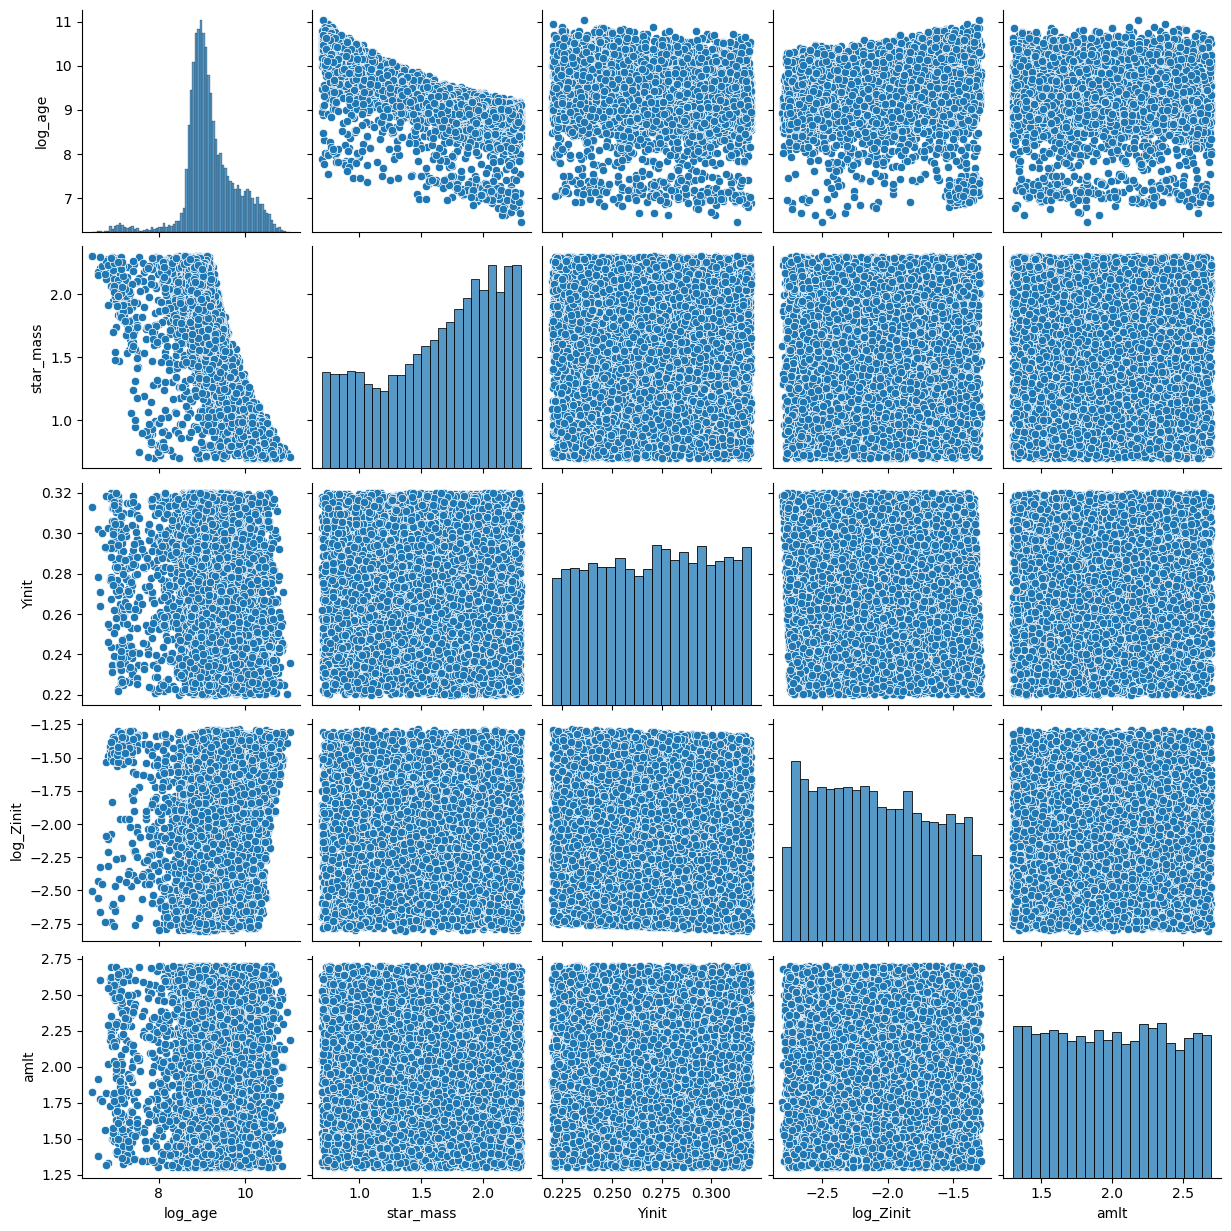

In [9]:
vars = ["log_age", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(grid.sample(10000), vars=vars);

The data needs some cleaning, there are low age patches.

In [10]:
grid["log_Teff"] = np.log10(grid.Teff)
grid["log_R"] = np.log10(grid.radius)
grid["log_Dnu"] = np.log10(grid.Dnu_freq_o)

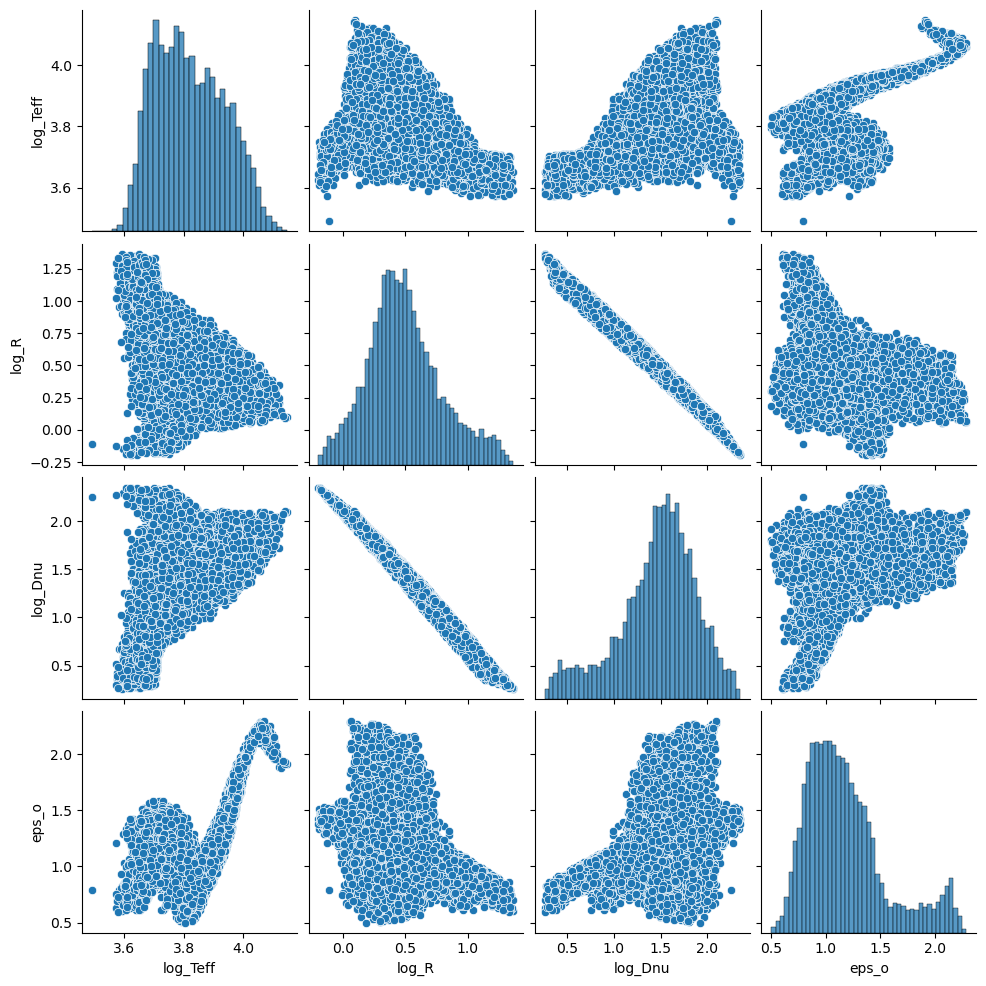

In [11]:
vars = ["log_Teff", "log_R", "log_Dnu", "eps_o"]
sns.pairplot(grid.sample(10000), vars=vars);

In [12]:
data = grid.dropna()
data.head()

track  star  star_mass     Yinit     Zinit      amlt  fov_core  fov_shell  \
0   7000     1    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
1   7000     2    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
2   7000     3    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
3   7000     4    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
4   7000     5    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   

       star_age    radius  ...    log_LHe  log_Lnuc  Dnu_freq_o     eps_o  \
0  2.220454e+07  0.893151  ... -45.291905  0.078416  148.565794  1.129515   
1  2.300916e+07  0.891027  ... -45.308912  0.077135  149.148739  1.131800   
2  2.397470e+07  0.890320  ... -45.328570  0.075916  149.362908  1.132830   
3  3.019433e+07  0.893682  ... -45.392646  0.075178  148.552167  1.130613   
4  3.259691e+07  0.894573  ... -45.402736  0.075810  148.331713  1.129892   

   delta_Pg  log_Zinit   log_age  log_Teff     log_R   log_Dnu  
0       0.0  -2.737812  7.346442  3.804991 -0.049075  2.171919  
1       0.0  -2.737812  7.361901  3.804638 -0.050109  2.173620  
2       0.0  -2.737812  7.379753  3.804397 -0.050454  2.174243  
3       0.0  -2.737812  7.479925  3.804236 -0.048817  2.171879  
4       0.0  -2.737812  7.513176  3.804239 -0.048384  2.171234  

[5 rows x 22 columns]

In [13]:
data["log_g"] = log_surface_gravity(data)
data["log_L"] = np.log10(luminosity(data))

In [14]:
with open("central_hydrogen_problem_tracks.txt") as file:
    bad = list(map(int, file.read().split(",")))

In [15]:
data = data.drop(index=data[data.track.isin(bad)].index)

In [16]:
keys = ["log_age", "log_Teff", "log_L"]
primary, secondary = calculate_eep(data, keys)
data["phase"] = primary
data["EEP"] = secondary

In [19]:
data = data.drop(index=data[data.phase == -1].index)
data

track  star  star_mass     Yinit     Zinit      amlt  fov_core  \
4         7000     5    0.92329  0.279311  0.001829  1.608258       0.0   
5         7000     6    0.92329  0.279311  0.001829  1.608258       0.0   
6         7000     7    0.92329  0.279311  0.001829  1.608258       0.0   
7         7000     8    0.92329  0.279311  0.001829  1.608258       0.0   
8         7000     9    0.92329  0.279311  0.001829  1.608258       0.0   
...        ...   ...        ...       ...       ...       ...       ...   
6587233   4999   480    0.99087  0.316689  0.036025  1.923737       0.0   
6587234   4999   481    0.99087  0.316689  0.036025  1.923737       0.0   
6587235   4999   482    0.99087  0.316689  0.036025  1.923737       0.0   
6587236   4999   483    0.99087  0.316689  0.036025  1.923737       0.0   
6587237   4999   484    0.99087  0.316689  0.036025  1.923737       0.0   

         fov_shell      star_age     radius  ...    log_age  log_Teff  \
4         0.006041  3.259691e+07   0.894573  ...   7.513176  3.804239   
5         0.006041  3.548000e+07   0.895385  ...   7.549984  3.804235   
6         0.006041  4.309136e+07   0.896934  ...   7.634390  3.804211   
7         0.006041  5.405171e+07   0.898494  ...   7.732809  3.804184   
8         0.006041  6.983463e+07   0.900101  ...   7.844071  3.804177   
...            ...           ...        ...  ...        ...       ...   
6587233   0.006041  1.446116e+10  11.974001  ...  10.160203  3.622522   
6587234   0.006041  1.446395e+10  12.438793  ...  10.160287  3.620797   
6587235   0.006041  1.446496e+10  12.619153  ...  10.160317  3.620149   
6587236   0.006041  1.446593e+10  12.798060  ...  10.160346  3.619526   
6587237   0.006041  1.446687e+10  12.979214  ...  10.160375  3.618881   

            log_R   log_Dnu     log_g     log_L   delta_X     f_nuc  phase  \
4       -0.048384  2.171234  4.500174  0.074879  0.001608  1.002145      0   
5       -0.047990  2.170650  4.499387  0.075651  0.001875  1.001741      0   
6       -0.047240  2.169543  4.497885  0.077058  0.002592  1.001313      0   
7       -0.046485  2.168433  4.496376  0.078459  0.003644  1.000889      0   
8       -0.045709  2.167280  4.494823  0.079984  0.005195  1.000489      0   
...           ...       ...       ...       ...       ...       ...    ...   
6587233  1.078239  0.496672  2.277606  1.601259  0.647286  0.994609      3   
6587234  1.094778  0.471924  2.244528  1.627438  0.647286  0.994784      3   
6587235  1.101030  0.462585  2.232024  1.637351  0.647286  0.994722      3   
6587236  1.107144  0.453453  2.219796  1.647086  0.647286  0.994695      3   
6587237  1.113248  0.444344  2.207588  1.656715  0.647286  0.994695      3   

              EEP  
4        0.000000  
5        0.017941  
6        0.042945  
7        0.069534  
8        0.097459  
...           ...  
6587233  3.969520  
6587234  3.977782  
6587235  3.983385  
6587236  3.988946  
6587237  3.994484  

[6228873 rows x 28 columns]

<Axes: ylabel='Frequency'>

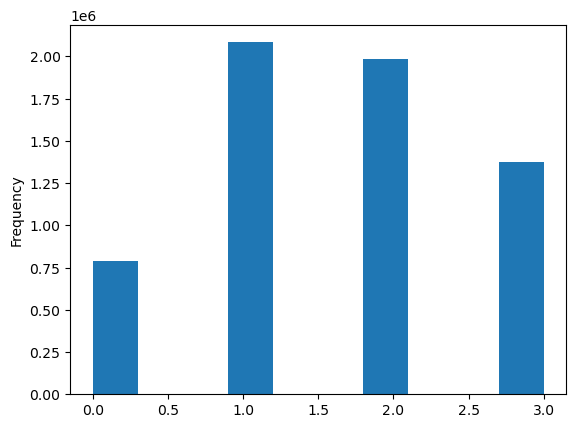

In [20]:
data.phase.plot(kind="hist")

In [21]:
ts = grid.track.sample(50)
mask = grid.track.isin(ts)

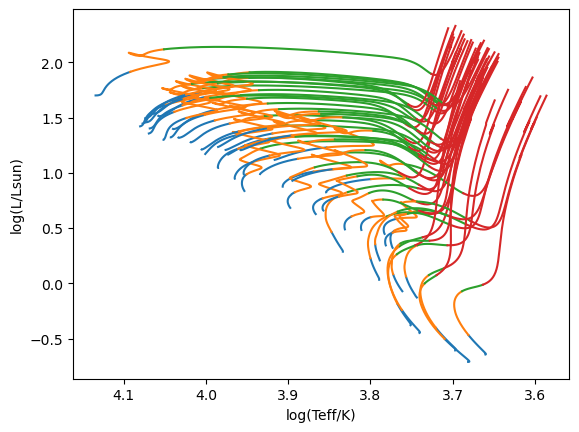

In [22]:
fig, ax = plt.subplots()

for idx, group in data.loc[mask].groupby(["track", "phase"], sort=False):
    label = None
    c = "gray" if idx[1] == -1 else f"C{idx[1]}"
    ax = group.plot(x="log_Teff", y="log_L", c=c, ax=ax, label=label)
#     ax.text(group.Teff.iloc[0], group.luminosity.iloc[0], idx[0])

ax.invert_xaxis()
# ax.invert_yaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")
# ax.legend(title="M, Yinit, Zinit, amlt")
ax.get_legend().remove()

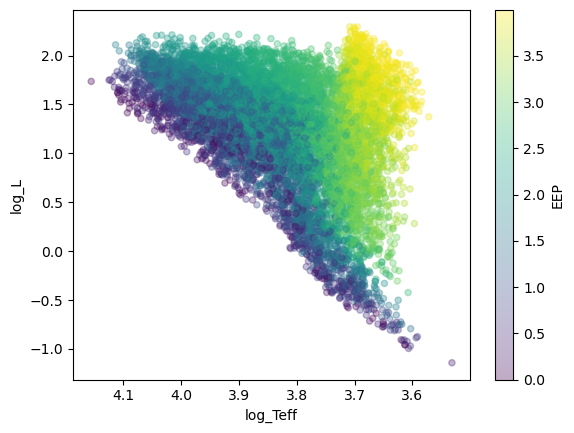

In [23]:
ax = data.sample(10000).plot(x="log_Teff", y="log_L", c="EEP", cmap="viridis", kind="scatter", alpha=0.33)
ax.invert_xaxis()

In [24]:
data["kron"] = data["star_age"] * data["star_mass"]**3.2
data["log_kron"] = np.log10(data["kron"])

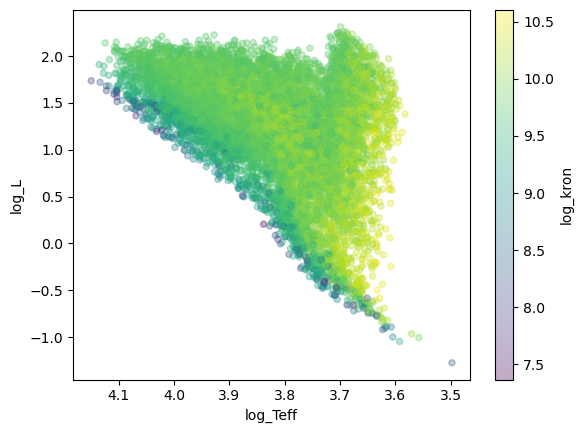

In [25]:
ax = data.sample(10000).plot(x="log_Teff", y="log_L", c="log_kron", cmap="viridis", kind="scatter", alpha=0.33)
ax.invert_xaxis()

In [28]:
rstate = 0
train = data.sample(frac=0.8, random_state=rstate)
test = data.drop(index=train.index)

In [29]:
# features = ["log_kron", "star_mass", "Yinit", "log_Zinit", "amlt"]
# sns.pairplot(train.sample(10000), vars=features);

In [30]:
# labels = ["log_Teff", "log_R", "log_Dnu"]
# sns.pairplot(train.sample(10000), vars=labels);

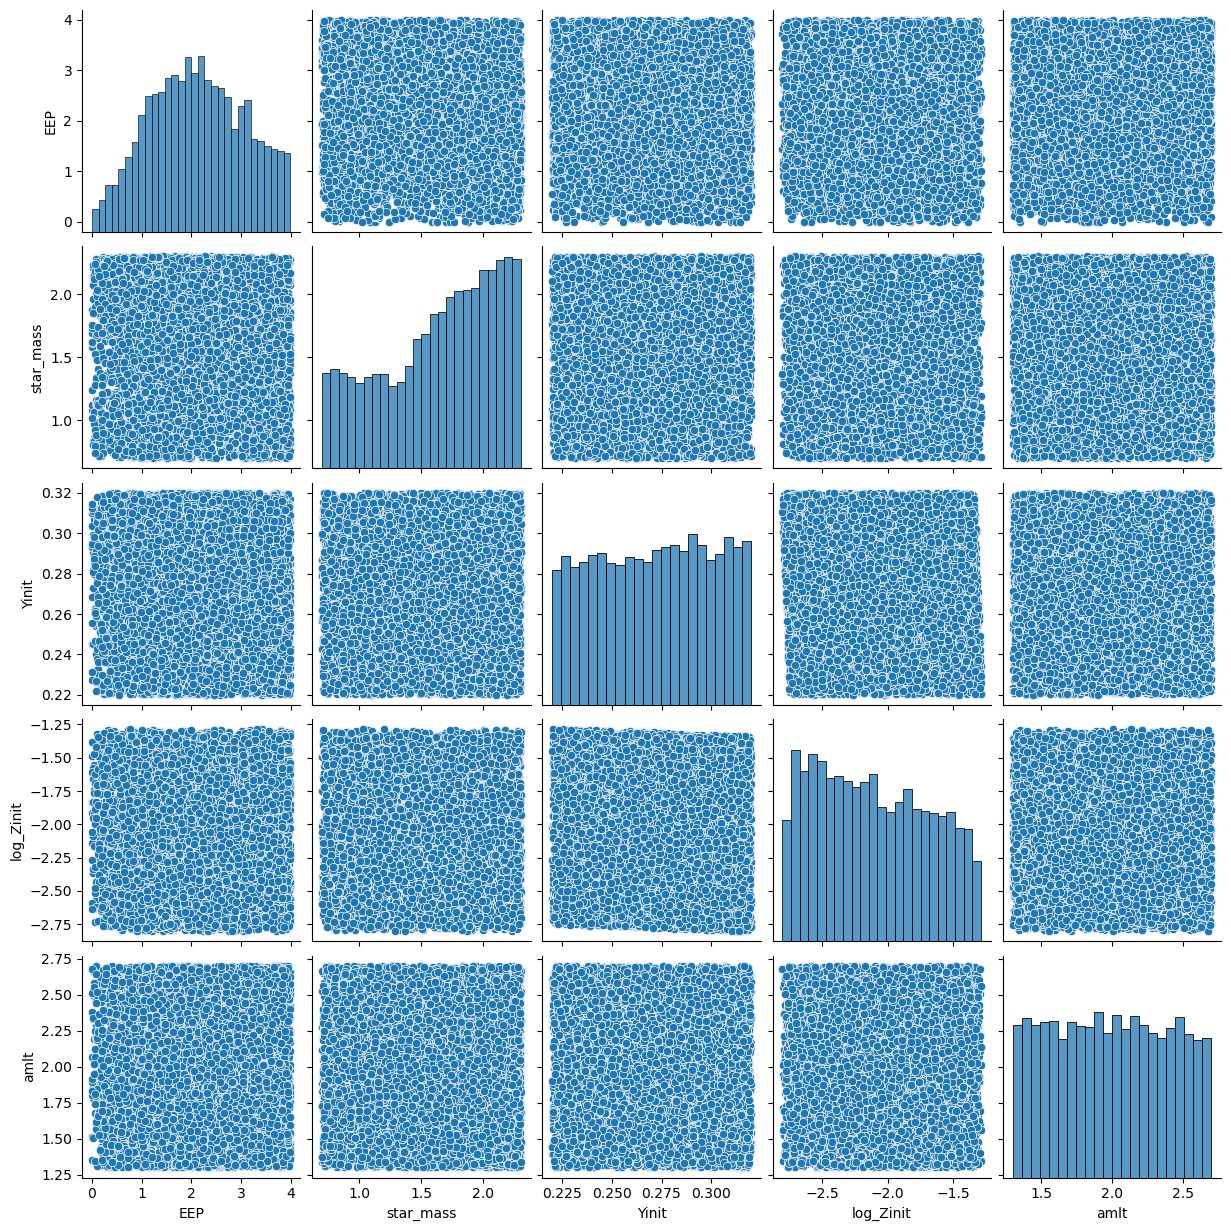

In [31]:
features = ["EEP", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(train.sample(10000), vars=features);

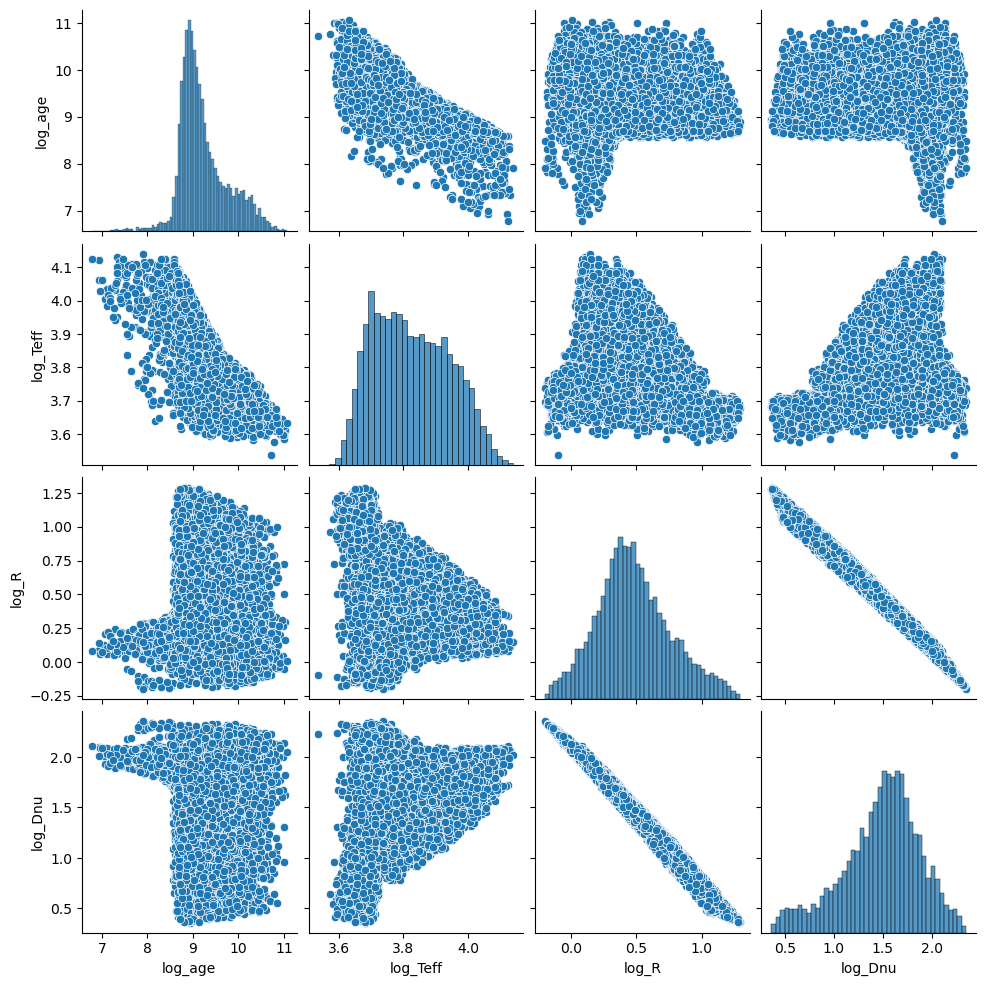

In [32]:
labels = ["log_age", "log_Teff", "log_R", "log_Dnu"]
sns.pairplot(train.sample(10000), vars=labels);

In [33]:
train_features = train[features].astype(np.float32).copy()
test_features = test[features].astype(np.float32).copy()

train_labels = train[labels].astype(np.float32).copy()
test_labels = test[labels].astype(np.float32).copy()

In [34]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features), batch_size=len(train_features))

2023-06-27 17:08:15.011331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18163 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-06-27 17:08:15.011769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18237 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


In [35]:
label_offset = train_labels.mean().to_numpy()
label_scale = train_labels.std().to_numpy()

rescaler = layers.Rescaling(label_scale, offset=label_offset)

In [36]:
num_features = len(features)
num_labels = len(labels)

In [37]:
class HyperModel(kt.HyperModel):
    def __init__(self, *args, max_iter=50000, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_iter = max_iter
        self.batch_size = None
        self.shuffle = None

    def build(self, hp):
        self.batch_size = hp.Choice("batch_size", values=[2**i for i in range(8, 18, 2)])
        self.shuffle = hp.Boolean("shuffle")

        units = hp.Choice('units_per_layer', values=[2**i for i in range(5, 10)])
        num_layers = hp.Int("hidden_layers", min_value=2, max_value=8, step=1)
        activation = "elu"
        
        model = tf.keras.Sequential(
            [normalizer] +
            [layers.Dense(units, activation) for _ in range(num_layers)] +
            [layers.Dense(num_labels), rescaler]
        )

        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        opt = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
        loss = 'mean_squared_error'

        model.compile(opt, loss=loss)
        return model

    def fit(self, hp, model, x, y, stop_early=True, monitor="val_loss", **kwargs):
#         batch_size = hp.Choice("batch_size", values=[2**i for i in range(8, 19, 2)])
        validation_split = kwargs.pop("validation_split", 0.0)
        epochs = kwargs.pop(
            "epochs",
            int(self.max_iter * self.batch_size / (1 - validation_split) / x.shape[0]) + 1
        )
        
        cbs = kwargs.pop("callbacks", [])
        if stop_early and not any(isinstance(cb, callbacks.EarlyStopping) for cb in cbs):
            patience = max(3, int(0.05*epochs))
            early_stopping = callbacks.EarlyStopping(monitor=monitor, patience=patience)
            cbs.append(early_stopping)

#         shuffle = hp.Boolean("shuffle")
        return model.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=self.batch_size,
            validation_split=validation_split,
            shuffle=self.shuffle,
            callbacks=cbs,
            **kwargs,
        )

In [48]:
hypermodel = HyperModel()

In [43]:
directory = '/mnt/data-storage/stellar-emulator/tuning'
project_name = datetime.now().strftime("%Y%m%d-%H%M%S")

In [50]:
tuner = kt.BayesianOptimization(
    hypermodel,
    objective='val_loss',
    max_trials=50,
    directory=directory,
#     overwrite=True,
    project_name=project_name,
)

In [51]:
tboard = callbacks.TensorBoard(f'/mnt/data-storage/stellar-emulator/tuning/{project_name}/logs')

In [52]:
tuner.search(
    train_features,
    train_labels,
    validation_split=0.2,
    callbacks=[tboard],
    stop_early=False,
)

Trial 49 Complete [00h 04m 51s]
val_loss: 7.720132998656482e-05

Best val_loss So Far: 3.5743221815209836e-05
Total elapsed time: 04h 28m 19s

Search: Running Trial #50

Value             |Best Value So Far |Hyperparameter
16384             |65536             |batch_size
False             |True              |shuffle
64                |256               |units_per_layer
2                 |6                 |hidden_layers
0.0001            |0.001             |learning_rate

Epoch 1/206
244/244 [==============================] - 1s 3ms/step - loss: 0.0597 - val_loss: 0.0275
Epoch 2/206
244/244 [==============================] - 1s 2ms/step - loss: 0.0224 - val_loss: 0.0200
Epoch 3/206
244/244 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0176
Epoch 4/206
244/244 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0153
Epoch 5/206
244/244 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0131
Epoch 6/206
244/24

244/244 [==============================] - 0s 2ms/step - loss: 2.6786e-04 - val_loss: 2.6686e-04
Epoch 72/206
244/244 [==============================] - 0s 2ms/step - loss: 2.6448e-04 - val_loss: 2.6356e-04
Epoch 73/206
244/244 [==============================] - 0s 2ms/step - loss: 2.6127e-04 - val_loss: 2.6105e-04
Epoch 74/206
244/244 [==============================] - 1s 2ms/step - loss: 2.5836e-04 - val_loss: 2.5791e-04
Epoch 75/206
244/244 [==============================] - 1s 2ms/step - loss: 2.5545e-04 - val_loss: 2.5456e-04
Epoch 76/206
244/244 [==============================] - 0s 2ms/step - loss: 2.5264e-04 - val_loss: 2.5200e-04
Epoch 77/206
244/244 [==============================] - 0s 2ms/step - loss: 2.5005e-04 - val_loss: 2.4920e-04
Epoch 78/206
244/244 [==============================] - 0s 2ms/step - loss: 2.4748e-04 - val_loss: 2.4681e-04
Epoch 79/206
244/244 [==============================] - 0s 2ms/step - loss: 2.4506e-04 - val_loss: 2.4431e-04
Epoch 80/206
244/244 [=

244/244 [==============================] - 0s 2ms/step - loss: 1.7983e-04 - val_loss: 1.8017e-04
Epoch 146/206
244/244 [==============================] - 0s 2ms/step - loss: 1.7955e-04 - val_loss: 1.8055e-04
Epoch 147/206
244/244 [==============================] - 0s 2ms/step - loss: 1.7941e-04 - val_loss: 1.7993e-04
Epoch 148/206
244/244 [==============================] - 0s 2ms/step - loss: 1.7906e-04 - val_loss: 1.7956e-04
Epoch 149/206
244/244 [==============================] - 0s 2ms/step - loss: 1.7835e-04 - val_loss: 1.7909e-04
Epoch 150/206
244/244 [==============================] - 0s 2ms/step - loss: 1.7794e-04 - val_loss: 1.7868e-04
Epoch 151/206
244/244 [==============================] - 0s 2ms/step - loss: 1.7771e-04 - val_loss: 1.7819e-04
Epoch 152/206
244/244 [==============================] - 0s 2ms/step - loss: 1.7731e-04 - val_loss: 1.7768e-04
Epoch 153/206
244/244 [==============================] - 0s 2ms/step - loss: 1.7708e-04 - val_loss: 1.7769e-04
Epoch 154/206
2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [70]:
best_hp = tuner.get_best_hyperparameters(num_trials=5)[2]  # <-- choose 'best'
best_model = tuner.hypermodel.build(best_hp)

In [71]:
best_hp.values

{'batch_size': 65536,
 'shuffle': True,
 'units_per_layer': 128,
 'hidden_layers': 7,
 'learning_rate': 0.001}

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [72]:
# import json

In [73]:
# trial_dir = tuner.get_trial_dir(19)
# with open(os.path.join(trial_dir, "trial.json")) as file:
#     d = json.loads(file.read())
# best_hp = kt.HyperParameters.from_config(d["hyperparameters"])
# best_model = tuner.hypermodel.build(best_hp)
# best_hp.values

In [74]:
history = hypermodel.fit(
    best_hp,
    best_model,
    train_features, 
    train_labels, 
    stop_early=False,
    epochs=1000,
)

Epoch 1/1000
77/77 [==============================] - 2s 8ms/step - loss: 0.0160
Epoch 2/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0043
Epoch 3/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 4/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 5/1000
77/77 [==============================] - 1s 8ms/step - loss: 7.7729e-04
Epoch 6/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.8395e-04
Epoch 7/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.2430e-04
Epoch 8/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.0365e-04
Epoch 9/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.3653e-04
Epoch 10/1000
77/77 [==============================] - 1s 8ms/step - loss: 3.5273e-04
Epoch 11/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.9853e-04
Epoch 12/1000
77/77 [==============================] - 1s 8ms/step - loss: 3.44

77/77 [==============================] - 1s 8ms/step - loss: 1.5625e-04
Epoch 97/1000
77/77 [==============================] - 1s 8ms/step - loss: 1.4748e-04
Epoch 98/1000
77/77 [==============================] - 1s 8ms/step - loss: 1.6642e-04
Epoch 99/1000
77/77 [==============================] - 1s 8ms/step - loss: 1.3663e-04
Epoch 100/1000
77/77 [==============================] - 1s 8ms/step - loss: 1.6450e-04
Epoch 101/1000
77/77 [==============================] - 1s 8ms/step - loss: 1.5805e-04
Epoch 102/1000
77/77 [==============================] - 1s 8ms/step - loss: 1.5036e-04
Epoch 103/1000
77/77 [==============================] - 1s 8ms/step - loss: 1.5329e-04
Epoch 104/1000
77/77 [==============================] - 1s 8ms/step - loss: 1.3665e-04
Epoch 105/1000
77/77 [==============================] - 1s 8ms/step - loss: 1.5368e-04
Epoch 106/1000
77/77 [==============================] - 1s 8ms/step - loss: 1.5772e-04
Epoch 107/1000
77/77 [==============================] - 1s 8m

77/77 [==============================] - 1s 8ms/step - loss: 9.2911e-05
Epoch 191/1000
77/77 [==============================] - 1s 8ms/step - loss: 9.8014e-05
Epoch 192/1000
77/77 [==============================] - 1s 8ms/step - loss: 9.8319e-05
Epoch 193/1000
77/77 [==============================] - 1s 8ms/step - loss: 8.7039e-05
Epoch 194/1000
77/77 [==============================] - 1s 8ms/step - loss: 9.7755e-05
Epoch 195/1000
77/77 [==============================] - 1s 8ms/step - loss: 8.9623e-05
Epoch 196/1000
77/77 [==============================] - 1s 8ms/step - loss: 1.0949e-04
Epoch 197/1000
77/77 [==============================] - 1s 8ms/step - loss: 9.0529e-05
Epoch 198/1000
77/77 [==============================] - 1s 8ms/step - loss: 8.9538e-05
Epoch 199/1000
77/77 [==============================] - 1s 8ms/step - loss: 8.8467e-05
Epoch 200/1000
77/77 [==============================] - 1s 8ms/step - loss: 9.7143e-05
Epoch 201/1000
77/77 [==============================] - 1s

77/77 [==============================] - 1s 8ms/step - loss: 7.3560e-05
Epoch 285/1000
77/77 [==============================] - 1s 8ms/step - loss: 7.6450e-05
Epoch 286/1000
77/77 [==============================] - 1s 8ms/step - loss: 7.2501e-05
Epoch 287/1000
77/77 [==============================] - 1s 8ms/step - loss: 7.3814e-05
Epoch 288/1000
77/77 [==============================] - 1s 8ms/step - loss: 7.4681e-05
Epoch 289/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.8400e-05
Epoch 290/1000
77/77 [==============================] - 1s 8ms/step - loss: 7.6800e-05
Epoch 291/1000
77/77 [==============================] - 1s 8ms/step - loss: 7.4912e-05
Epoch 292/1000
77/77 [==============================] - 1s 8ms/step - loss: 8.4238e-05
Epoch 293/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.9429e-05
Epoch 294/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.9114e-05
Epoch 295/1000
77/77 [==============================] - 1s

77/77 [==============================] - 1s 8ms/step - loss: 7.2468e-05
Epoch 379/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.8230e-05
Epoch 380/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.3950e-05
Epoch 381/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.0267e-05
Epoch 382/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.5431e-05
Epoch 383/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.5347e-05
Epoch 384/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.0606e-05
Epoch 385/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.9998e-05
Epoch 386/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.4937e-05
Epoch 387/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.1500e-05
Epoch 388/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.2336e-05
Epoch 389/1000
77/77 [==============================] - 1s

77/77 [==============================] - 1s 8ms/step - loss: 5.8810e-05
Epoch 473/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.2075e-05
Epoch 474/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.6371e-05
Epoch 475/1000
77/77 [==============================] - 1s 8ms/step - loss: 6.3864e-05
Epoch 476/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.1521e-05
Epoch 477/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.6492e-05
Epoch 478/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.4101e-05
Epoch 479/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.8109e-05
Epoch 480/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.6023e-05
Epoch 481/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.4169e-05
Epoch 482/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.1800e-05
Epoch 483/1000
77/77 [==============================] - 1s

77/77 [==============================] - 1s 8ms/step - loss: 5.2452e-05
Epoch 567/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.2629e-05
Epoch 568/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.9459e-05
Epoch 569/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.9330e-05
Epoch 570/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.2398e-05
Epoch 571/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.5481e-05
Epoch 572/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.5733e-05
Epoch 573/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.0364e-05
Epoch 574/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.3352e-05
Epoch 575/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.9050e-05
Epoch 576/1000
77/77 [==============================] - 1s 8ms/step - loss: 5.4342e-05
Epoch 577/1000
77/77 [==============================] - 1s

77/77 [==============================] - 1s 8ms/step - loss: 4.6808e-05
Epoch 661/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.7174e-05
Epoch 662/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.8888e-05
Epoch 663/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.6858e-05
Epoch 664/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.8113e-05
Epoch 665/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.7369e-05
Epoch 666/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.9800e-05
Epoch 667/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.4551e-05
Epoch 668/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.6430e-05
Epoch 669/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.7583e-05
Epoch 670/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.7442e-05
Epoch 671/1000
77/77 [==============================] - 1s

77/77 [==============================] - 1s 8ms/step - loss: 4.2203e-05
Epoch 755/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.6410e-05
Epoch 756/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.5014e-05
Epoch 757/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.5159e-05
Epoch 758/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.6575e-05
Epoch 759/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.3674e-05
Epoch 760/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.5922e-05
Epoch 761/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.2739e-05
Epoch 762/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.6777e-05
Epoch 763/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.6381e-05
Epoch 764/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.5909e-05
Epoch 765/1000
77/77 [==============================] - 1s

77/77 [==============================] - 1s 8ms/step - loss: 3.9108e-05
Epoch 849/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.0007e-05
Epoch 850/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.4963e-05
Epoch 851/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.2803e-05
Epoch 852/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.2127e-05
Epoch 853/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.6847e-05
Epoch 854/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.2225e-05
Epoch 855/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.0719e-05
Epoch 856/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.5486e-05
Epoch 857/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.1653e-05
Epoch 858/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.3928e-05
Epoch 859/1000
77/77 [==============================] - 1s

77/77 [==============================] - 1s 8ms/step - loss: 4.1442e-05
Epoch 943/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.3088e-05
Epoch 944/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.0155e-05
Epoch 945/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.0038e-05
Epoch 946/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.3735e-05
Epoch 947/1000
77/77 [==============================] - 1s 8ms/step - loss: 3.9775e-05
Epoch 948/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.0429e-05
Epoch 949/1000
77/77 [==============================] - 1s 9ms/step - loss: 4.1298e-05
Epoch 950/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.2585e-05
Epoch 951/1000
77/77 [==============================] - 1s 8ms/step - loss: 4.3391e-05
Epoch 952/1000
77/77 [==============================] - 1s 8ms/step - loss: 3.9797e-05
Epoch 953/1000
77/77 [==============================] - 1s

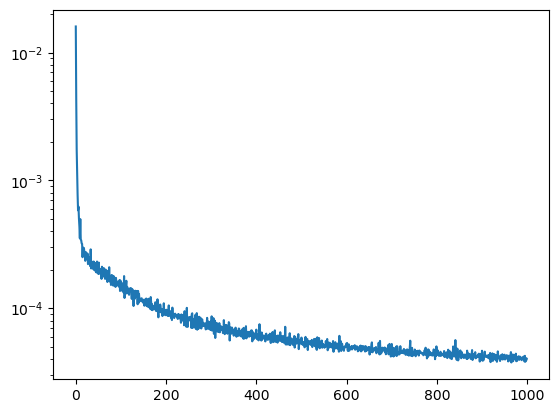

In [75]:
fig, ax = plt.subplots()

ax.plot(history.epoch, history.history["loss"]);
ax.set_yscale("log")

In [76]:
num_points = 201
example_features = np.stack([
    np.linspace(0, 4, num_points),
    np.ones(num_points) * 1.0,
    np.ones(num_points) * 0.26,
    np.ones(num_points) * -2,
    np.ones(num_points) * 2,
], axis=-1)

example_labels = best_model(example_features).numpy()

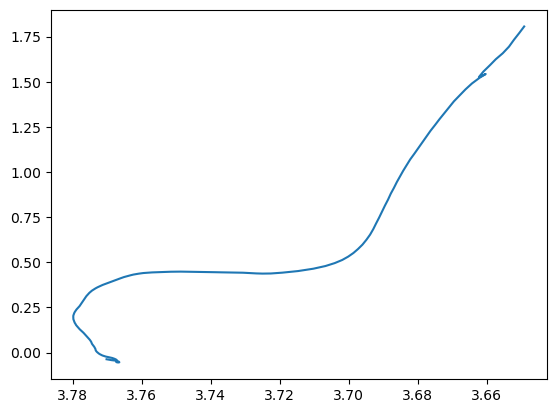

In [77]:
fig, ax = plt.subplots()


log_L = 2 * example_labels[:, 2] + 4 * (example_labels[:, 1] - np.log10(5772.))
ax.plot(example_labels[:, 1], log_L)
ax.invert_xaxis()

In [78]:
train_pred = best_model(train_features)
log_error = train_labels - train_pred.numpy()

Text(0, 0.5, 'log(L/Lsun)')

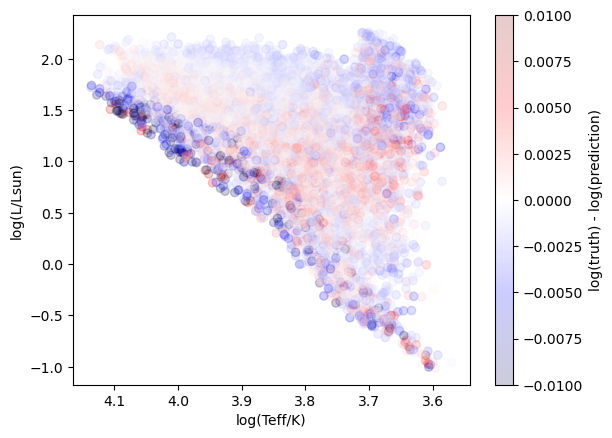

In [79]:
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, data.loc[sample.index, "log_L"], c=log_error.loc[sample.index].mean(axis=1), 
               cmap="seismic", alpha=0.2, vmin=-0.01, vmax=0.01)
fig.colorbar(s, label="log(truth) - log(prediction)")

ax.invert_xaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

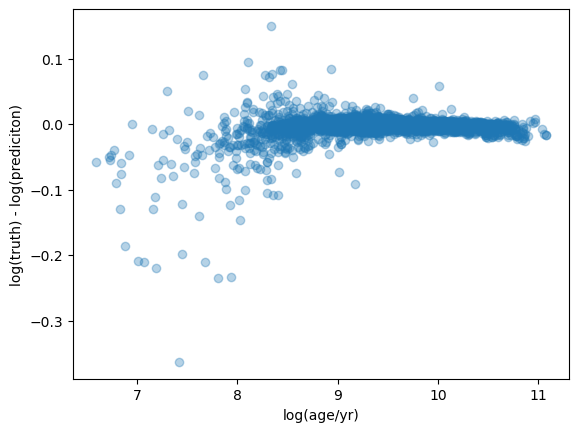

In [80]:
key = "log_age"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(age/yr)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

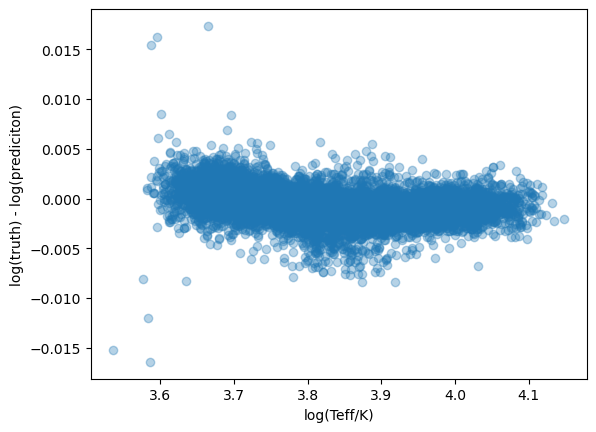

In [81]:
key = "log_Teff"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

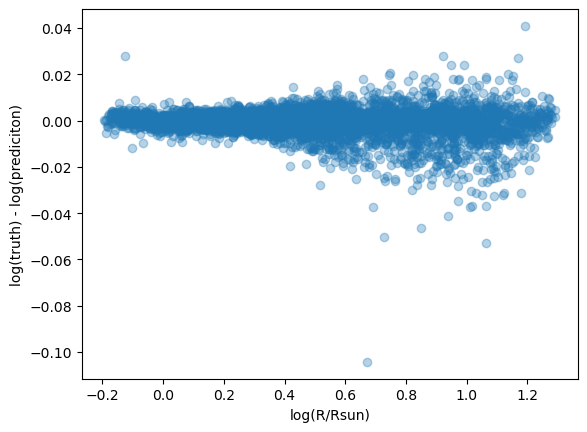

In [82]:
key = "log_R"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(R/Rsun)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

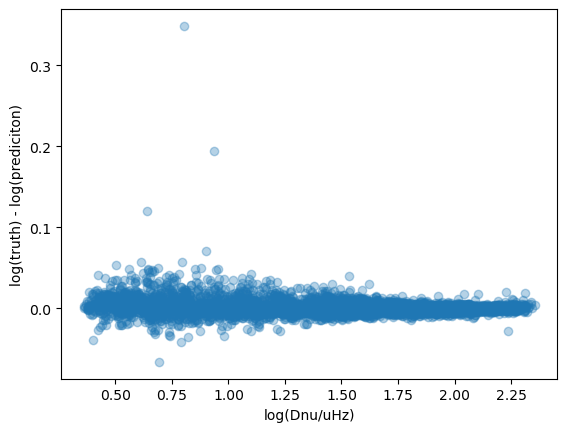

In [84]:
key = "log_Dnu"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(Dnu/uHz)")
ax.set_ylabel("log(truth) - log(prediciton)")

In [88]:
train_pred = pd.DataFrame(train_pred, index=train.index, columns=["log_age", "log_Teff", "log_R", "log_Dnu"])
train_pred["log_L"] = 2 * train_pred["log_R"] + 4 * (train_pred["log_Teff"] - np.log10(5772.))

In [89]:
error = 10**train_labels - 10**train_pred

In [90]:
error.std()

log_Dnu     4.446557e-01
log_L                NaN
log_R       8.597057e-02
log_Teff    2.556183e+01
log_age     1.765172e+08
dtype: float64

In [91]:
(10**train["log_L"] - 10**train_pred["log_L"]).std()

0.8184800403186487

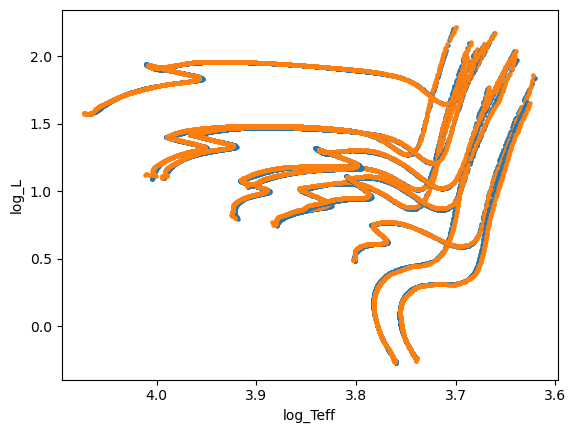

In [92]:
fig, ax = plt.subplots()
for ti in train.track.sample(10, random_state=0):
    mask = train.track == ti
    ax = train.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", marker=".", ax=ax)
    ax = train_pred.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", c="C1", marker=".", ax=ax)

ax.invert_xaxis();

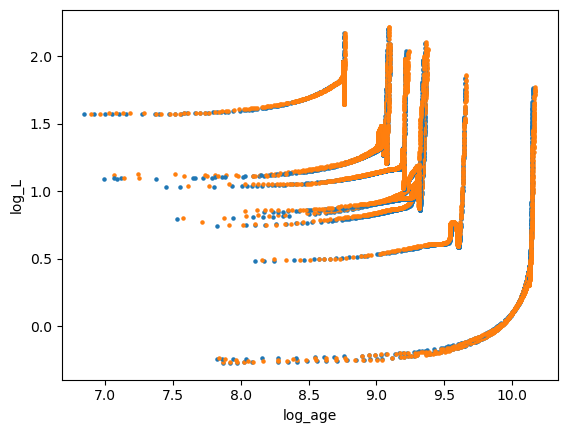

In [93]:
fig, ax = plt.subplots()
for ti in train.track.sample(10, random_state=0):
    mask = train.track == ti
    ax = train.loc[mask].plot(x="log_age", y="log_L", kind="scatter", marker=".", ax=ax)
    ax = train_pred.loc[mask].plot(x="log_age", y="log_L", kind="scatter", c="C1", marker=".", ax=ax)

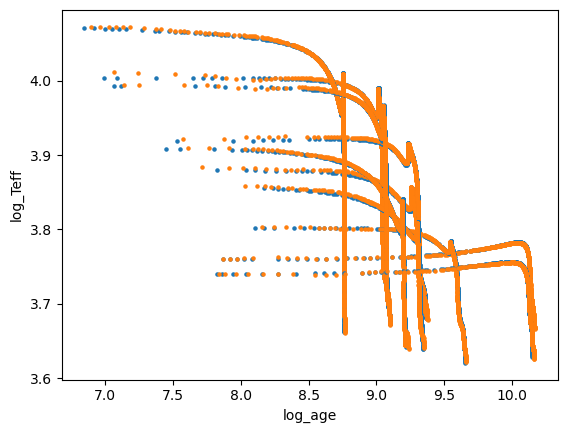

In [94]:
fig, ax = plt.subplots()
for ti in train.track.sample(10, random_state=0):
    mask = train.track == ti
    ax = train.loc[mask].plot(x="log_age", y="log_Teff", kind="scatter", marker=".", ax=ax)
    ax = train_pred.loc[mask].plot(x="log_age", y="log_Teff", kind="scatter", c="C1", marker=".", ax=ax)

In [95]:
filepath = os.path.join(directory, project_name, "best", "model.tf")
best_model.save(filepath)

INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20230627-173049/best/model.tf/assets


In [110]:
import json

In [115]:
history_dict = dict(
    history=history.history,
    params=history.params,
    epoch=history.epoch,
)

In [116]:
with open("test.json", "w") as file:
    s = json.dumps(history_dict)
    file.write(s)

In [ ]:
callbacks.ModelCheckpoint()

In [ ]:
callbacks.EarlyStopping()